In [1]:
import matplotlib.gridspec as gridspec
from hydroDL.post import axplot, figplot, mapplot
import matplotlib.pyplot as plt
from hydroDL import utils
import os
from hydroDL.model import trainBasin, crit, waterNetTest
from hydroDL.data import dbBasin, gageII
import numpy as np
import torch
import pandas as pd
from hydroDL.model import waterNetTest, waterNet
from hydroDL.master import basinFull
import importlib


loading package hydroDL


In [2]:
dataName = 'QN90ref'
DF = dbBasin.DataFrameBasin(dataName)
varX = ['pr', 'etr', 'tmmn', 'tmmx', 'srad', 'LAI']
mtdX = ['skip' for k in range(2)] +\
    ['scale' for k in range(2)] +\
    ['norm' for k in range(2)]
varY = ['runoff']
mtdY = ['skip']
varXC = gageII.varLstEx
mtdXC = ['QT' for var in varXC]
varYC = None
mtdYC = dbBasin.io.extractVarMtd(varYC)
# train
trainSet = 'WYB09'
testSet = 'WYA09'
DM1 = dbBasin.DataModelBasin(
    DF, subset=trainSet, varX=varX, varXC=varXC, varY=varY, varYC=varYC)
DM1.trans(mtdX=mtdX, mtdXC=mtdXC)
dataTup1 = DM1.getData()
DM2 = dbBasin.DataModelBasin(
    DF, subset=testSet, varX=varX, varXC=varXC, varY=varY, varYC=varYC)
DM2.borrowStat(DM1)
dataTup2 = DM2.getData()

# model
nh = 16
ng = len(varXC)
ns = len(DF.siteNoLst)
nr = 5
model = waterNet.WaterNet0119(nh, len(varXC), nr)
model = model.cuda()
optim = torch.optim.Adam(model.parameters())
lossFun = crit.LogLoss2D().cuda()

Find negative Q, filled zero


C:\Users\geofk\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


694 extremes removed
loading data QN90ref 11.23s


In [3]:
# water net
saveDir = r'C:\Users\geofk\work\waterQuality\waterNet\modelTemp'
modelFile = 'wn0119-{}-ep{}'.format('QN90ref', 100)
model.load_state_dict(torch.load(os.path.join(saveDir, modelFile)))
model.eval()
[x, xc, y, yc] = dataTup2
xP = torch.from_numpy(x).float().cuda()
xcP = torch.from_numpy(xc).float().cuda()
nt, ns, _ = y.shape
t = DF.getT(testSet)
testBatch = 100
iS = np.arange(0, ns, testBatch)
iE = np.append(iS[1:], ns)
yP = np.ndarray([nt-nr+1, ns])
for k in range(len(iS)):
    print('batch {}'.format(k))
    yOut = model(xP[:, iS[k]:iE[k], :], xcP[iS[k]:iE[k]])
    yP[:, iS[k]:iE[k]] = yOut.detach().cpu().numpy()
model.zero_grad()

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5


In [5]:
# LSTM
outName = '{}-{}'.format('QN90ref', trainSet)
yL, ycL = basinFull.testModel(
    outName, DF=DF, testSet=testSet, reTest=False, ep=1000)
yL = yL[:, :, 0]
nash1 = utils.stat.calNash(yP, y[nr-1:, :, 0])
corr1 = utils.stat.calCorr(yP, y[nr-1:, :, 0])
nash2 = utils.stat.calNash(yL, y[:, :, 0])
corr2 = utils.stat.calCorr(yL, y[:, :, 0])
lat, lon = DF.getGeo()

load saved test result


In [7]:

def funcM():
    figM = plt.figure(figsize=(12, 5))
    gsM = gridspec.GridSpec(1, 3)
    axM0 = mapplot.mapPoint(figM, gsM[0, 0], lat, lon, nash1)
    axM0.set_title('waterNet Nash')
    axM1 = mapplot.mapPoint(figM, gsM[0, 1], lat, lon, nash2)
    axM1.set_title('LSTM Nash')
    axM2 = mapplot.mapPoint(figM, gsM[0, 2], lat, lon, nash2-nash1)
    axM2.set_title('LSTM - waterNet Nash')
    axM = np.array([axM0, axM1, axM2])
    figP, axP = plt.subplots(1, 1, figsize=(12, 4))
    return figM, axM, figP, axP, lon, lat


def funcP(iP, axP):
    print(iP)
    siteNo = DF.siteNoLst[iP]
    t = DF.getT(testSet)
    legLst = ['obs',
              'waterNet {:.2f} {:.2f}'.format(nash1[iP], corr1[iP]),
              'LSTM {:.2f} {:.2f}'.format(nash2[iP], corr2[iP])
              ]
    axplot.plotTS(axP, t[nr-1:], [y[nr-1:, iP, 0], yP[:, iP], yL[nr-1:, iP]],
                  lineW=[2, 1, 1], cLst='krb', legLst=legLst)
    strTitle = ('{}'.format(DF.siteNoLst[iP]))
    axP.set_title(strTitle)

C:\Users\geofk\work\GitHUB\geolearn\hydroDL\post\figplot.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figM.show()
C:\Users\geofk\work\GitHUB\geolearn\hydroDL\post\figplot.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figP.show()


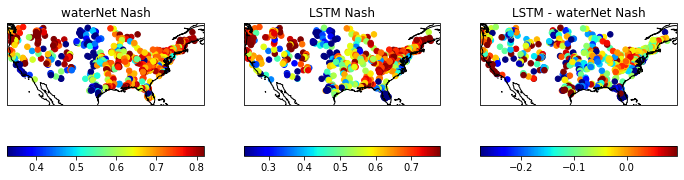

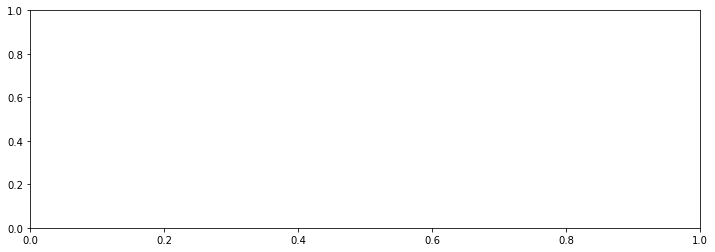

In [19]:
%matplotlib inline
figM, figP = figplot.clickMap(funcM, funcP)

C:\Users\geofk\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


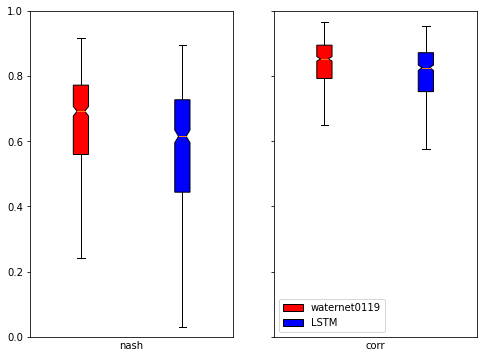

In [20]:
fig, axes = figplot.boxPlot([[nash1, nash2], [corr1, corr2]],
                            label1=['nash', 'corr'],
                            label2=['waternet0119', 'LSTM'],
                            yRange=[0, 1])
fig.show()

C:\Users\geofk\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


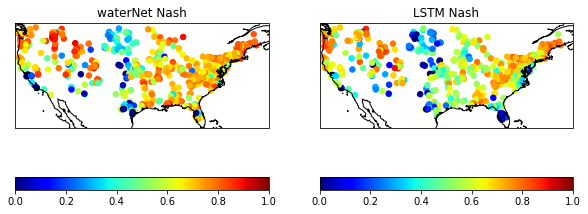

In [23]:
figM = plt.figure(figsize=(10,6))
gsM = gridspec.GridSpec(1, 2)
axM0 = mapplot.mapPoint(figM, gsM[0, 0], lat, lon, nash1, vRange=[0, 1])
axM0.set_title('waterNet Nash')
axM1 = mapplot.mapPoint(figM, gsM[0, 1], lat, lon, nash2, vRange=[0, 1])
axM1.set_title('LSTM Nash')
figM.show()